# 0. Import Data

In [3]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


import csv
import math
import mplleaflet
import matplotlib.pyplot as plt
import pandas as pd
import gps_utils as gps
import time as ttt

current_milli_time = lambda: int(round(ttt.time() * 1000))

In [166]:
with open('../test.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')

    latitude_list = []
    longitude_list = []
    time_list = []
    # breaks only for development purposes
    counter = 0
    time = 0
    
    # for development only
    # test ist eine Liste mit allen Trajectories, jeder Traejctory ist ein (Pandas-) Dataframe mit den Spalten lon, lat, time
    test = []
    
    for row in csv_reader:
        cleared = row[8].replace("],[", " -1 ").replace("[[", "").replace("]]", "")
        if cleared != "POLYLINE":
            splitted = cleared.split(" -1 ")
            # extractes all the points
            for entry in splitted:
                data = entry.split(",")
                latitude_list.append(data[1])
                longitude_list.append(data[0])
                time_list.append(time)
                time += 15
            counter += 1
            time = 0
            # creats a trajectory dataframe
            coords = pd.DataFrame({'lon': longitude_list, 'lat': latitude_list, 'time': time_list})
            test.append(coords)
            # reset everything 
            latitude_list = []
            longitude_list = []
            time_list = []
            # breaks only for development purposes
            if counter == 35:
                break

# 1. Initial Data 

In [9]:
# retrieve the test route
coords = test[16]
coords.lon = coords.lon.astype(float)
coords.lat = coords.lat.astype(float)

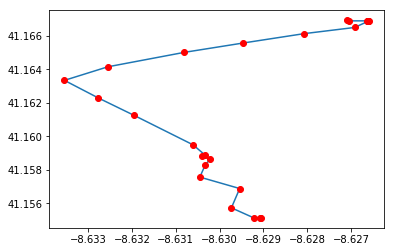

In [10]:
fig = plt.figure()
simplified_coords = coords[['lon', 'lat']].values
plt.plot(simplified_coords[:,0], simplified_coords[:,1])
plt.plot(simplified_coords[:,0], simplified_coords[:,1], 'ro')

In [11]:
mplleaflet.display(fig=fig)

# 2. Trajectory Partition

## 2.1. Stop Point Extraction (TDBC)
Referenz: Z. Fu, Z. Tian, Y. Xu, and C. Qiao, ‘‘A two-step clustering approach to extract locations from individual GPS trajectory data,’’ ISPRS Int. J. Geo- Inf., vol. 5, no. 10, p. 166, 2016.

Auch bei Github hochgeladen als spe-tdbc.pdf

In [12]:
def centroid(lonT, latT):
    # https://stackoverflow.com/questions/6671183/calculate-the-center-point-of-multiple-latitude-longitude-coordinate-pairs
    
    # lonT = [13.341664, 13.374373, 13.376003, 13.352830]
    # latT = [52.519198, 52.523039, 52.504053, 52.508498]
    
    '''
    benchmark beginns
    '''
    start_time = current_milli_time()
    
    
    if (len(lonT) == 0 or len(latT)== 0):
        return 0, 0

    xList = []
    yList = []
    zList = []

    dataT = pd.DataFrame({'lat': latT, 'lon': lonT})
    for index, row in dataT.iterrows():
        lat = row['lat'] * math.pi / 180
        lon = row['lon'] * math.pi / 180
        X = math.cos(lat) * math.cos(lon)
        Y = math.cos(lat) * math.sin(lon)
        Z = math.sin(lat)
        xList.append(X)
        yList.append(Y)
        zList.append(Z)

    dataXYZ = pd.DataFrame({'x': xList, 'y': yList, 'z': zList})

    x = 0
    y = 0
    z = 0
    n = 0

    for index, row in dataXYZ.iterrows():
        x += row['x']
        y += row['y']
        z += row['z']
        n += 1

    aX = x / n
    aY = y / n
    aZ = z / n

    Lon = math.atan2(y, x) * 180 / math.pi
    Hyp = math.sqrt(x * x + y * y)
    Lat = math.atan2(z, Hyp) * 180 / math.pi
    
    '''
    benchmark ends
    '''
    time = (current_milli_time() - start_time)
    print("----------centroid(...): BEGIN----------")
    print("time consumption in ms: {}".format(time))
    print("----------centroid(...): END----------")
    
    return Lon, Lat

In [13]:
def stop_point_extraction(trajectory, time_threshold, distance_threshold):
    
    '''
    benchmark beginns
    '''
    start_time = current_milli_time()
    
    # leere Cluster, c_cluster ist Cluster aus dem Paper, p_cluster ist Previous C
    c_cluster = pd.DataFrame(columns=['lon', 'lat', 'time'])
    p_cluster = pd.DataFrame(columns=['lon', 'lat', 'time'])
    stop_points = pd.DataFrame(columns=['lon', 'lat', 'time'])
    stop_points_cluster = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
    # p_point ist Previous stop point in SP aus dem Paper, relevant für Zeile 9 und 11 aus dem Paper
    p_point = None
    c_point = None
    # Boolean Flag, nur relevant für die check Funktion
    is_type2 = False
    # braucht man nicht wirklich
    counter = 0

    def start_end(cluster):
        min_time = min(cluster['time'].tolist())
        max_time = max(cluster['time'].tolist())
        return min_time, max_time

    def add_stop_point(cluster):
        # print("-------------------BEGIN: add_stop_point(cluster)---------------------")
        # nonlocal, damit auf die Variablen der übergeordneten Funktion aufgerufen und bearbeiten werden kann
        nonlocal p_cluster
        nonlocal stop_points
        nonlocal stop_points_cluster
        nonlocal c_cluster
        # Variablen Initialisierung
        p_stop_point = None
        # Nur relevant für die Initailisierung des Algorithmuses: wenn kein Stopppunkt vorhanden,
        # füge das aktuelle Cluster oder Punkt der Liste der Stopppunkte hinzu
        # print("-> cluster:")
        # print(cluster)
        min_time, max_time = start_end(cluster)
        if len(stop_points.tail(1)['lon'].values) == 0:
            stop_points = stop_points.append(cluster, ignore_index=True)
            spc_frame = pd.DataFrame(
                {"lon": [cluster['lon'][0]], "lat": [cluster['lat'][0]], "tstart": [cluster['time'][0]]})
            stop_points_cluster = stop_points_cluster.append(spc_frame, ignore_index=True)
            p_cluster = cluster
            # print("--> initial SP")
            # print("-> stop_points:")
            # print(stop_points)
            # print("-> stop_points_cluster:")
            # print(stop_points_cluster)
        else:
            p_stop_point = stop_points_cluster.tail(1)['lon'].values[0], stop_points_cluster.tail(1)['lat'].values[0]
            cluster_coord = centroid(cluster['lon'].tolist(), cluster['lat'].tolist())
            # gps.haversine(coord1, coord2) berechnet die Distanc in Metern zwischen zwei Koordinaten
            # coord1 und coord2 müssen als Dataframe mit den Spalten lon und lat vorliegen
            # print("-> p_stop_point")
            # print(p_stop_point)
            # print("-> cluster")
            # print(cluster_coord)
            # print("-> distance between cluster and p_stop_point")
            # print(gps.haversine(cluster_coord, p_stop_point))
            if gps.haversine(cluster_coord, p_stop_point) < distance_threshold:
                # hängt alle Punkte des Clusters oder einzelnen Punkt an den p_cluster (vorheriger Cluster)
                p_stop_point_lon, p_stop_point_lat = p_stop_point
                test_point = centroid([p_stop_point_lon], [p_stop_point_lon])
                test_point_frame = pd.DataFrame(
                    {"lon": [p_stop_point_lon], "lat": [p_stop_point_lat], "tstart": [min_time], "tend": [max_time]})
                stop_points = pd.concat([stop_points, cluster]).drop_duplicates().reset_index(drop=True)
                stop_points_cluster = stop_points_cluster.drop(stop_points_cluster.tail(1).index, inplace=True)
                stop_points_cluster = pd.concat([stop_points_cluster, test_point_frame]).drop_duplicates().reset_index(
                    drop=True)
                # print("--> Added c_cluster to p_cluster!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")
                # print("-> c_cluster:")
                # print(c_cluster)
                # print("-> p_cluster:")
                # print(p_cluster)
                c_cluster = c_cluster.iloc[0:0]
            else:
                centeroid_lon, centeroid_lat = cluster_coord
                if centeroid_lon != 0:
                    data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
                    sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
                    stop_points = stop_points.append(cluster, ignore_index=True)
                    stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
                    p_cluster = cluster
                    # Dataframe.iloc[0:0] löscht den Inhalt eines Dataframes, hier den Inhalt von c_cluster
                    c_cluster = c_cluster.iloc[0:0]
                    # print("---> p_cluster = cluster / drop c_cluster")
            # print("-> stop_points:")
            # print(stop_points)
            # print("-> stop_points_cluster:")
            # print(stop_points_cluster)
        # print("-------------------END: add_stop_point(cluster)---------------------")

    def check():
        # print("-------------------BEGIN: check()---------------------")
        nonlocal c_cluster
        nonlocal p_cluster
        nonlocal is_type2
        # centroid(coods, coords) berechnet den Mittelpunkt, Argumente, sind jeweils eine Liste von lon und lat
        c_cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        p_cluster_coord = centroid(p_cluster['lon'].tolist(), p_cluster['lat'].tolist())
        # print("---> BEFORE:")
        # print("-> c_cluster:")
        # print(c_cluster)
        # print("-> p_cluster:")
        # print(p_cluster)
        # print("-> time_interval:")
        # print(time_interval())
        # print("-> distance c_cluster_coord, p_cluster_coord:")
        # print(gps.haversine(c_cluster_coord, p_cluster_coord))
        if (time_interval() < time_threshold and gps.haversine(c_cluster_coord, p_cluster_coord) < distance_threshold):
            # p_cluster wird erweitert mit c_cluster, Duplikate werden gelöscht
            p_cluster = p_cluster.append(c_cluster).drop_duplicates().reset_index(drop=True)
            # print("-> p_cluster")
            # print(p_cluster)
            # print("-> is_type2")
            # print(is_type2)
            if is_type2 == True:
                # print("----> add_stop_point(p_cluster)")
                add_stop_point(p_cluster)
                is_type2 == False
                # c_cluster = c_cluster.iloc[0:0]
            else:
                # print("----> p_cluster = c_cluster / drop c_cluster")
                p_cluster = c_cluster
                # löschen des Inhalts von c_cluster
                # c_cluster = c_cluster.iloc[0:0]
        else:
            # pass
            add_stop_point(c_cluster)
        # print("---> AFTER:")
        # print("-> c_cluster:")
        # print(c_cluster)
        # print("-> p_cluster:")
        # print(p_cluster)
        # print("-------------------END: check()---------------------")

    def time_interval():
        nonlocal c_cluster
        nonlocal p_cluster
        # wenn p_cluster leer, dann return 0 als Zeitinterval
        if p_cluster.shape[0] == 0:
            return 0
        # berechnet den Zeitinterval von zwei Clustern, indem der Maximalwert (Zeit) der beiden Cluster - Minimalwert
        min_time = min([c_cluster.iloc[[0]]['time'].tolist()[0], p_cluster.iloc[[0]]['time'].tolist()[0]])
        max_time = max([c_cluster.iloc[[-1]]['time'].tolist()[0], p_cluster.iloc[[-1]]['time'].tolist()[0]])
        return abs(max_time - min_time)

    def duration():
        nonlocal c_cluster
        min_time = min(c_cluster['time'].tolist())
        max_time = max(c_cluster['time'].tolist())
        return max_time - min_time

    p_coord = None
    skip = False
    # adds the first and last trajectory points as type 1 stop points
    # if counter == 0 or counter == trajectory.shape[0]-1:

    first_sp_lon = trajectory.iloc[0].values[0]
    first_sp_lat = trajectory.iloc[0].values[1]
    first_sp_frame = pd.DataFrame({"lon": [first_sp_lon], "lat": [first_sp_lat], "time": [0]})
    # print(first_sp_frame)
    add_stop_point(first_sp_frame)
    for index, point in trajectory.iterrows():
        c_point = point
        point_coord = point['lon'], point['lat']
        point_frame = pd.DataFrame({"lon": [point['lon']], "lat": [point['lat']], "time": [point['time']]})
        # print("_____________________________________________________________________________")
        # print(point_frame)
        # print("-> p_coord:")
        # print(p_coord)
        # print("-> point_coord:")
        # print(point_coord)
        # if p_coord != None:
        # print("-> distance between p_coord and point_coord:")
        # print(gps.haversine(p_coord, point_coord))
        # Lösungsvorschlag, wenn der initiale Cluster leer ist, dann füge aktuellen Punkt hinzu
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        # # print(gps.haversine(cluster_coord, point_coord))
        # # print(cluster_coord, point_coord)
        # Punkte des Typ 2 sind der 1,2,3 Fall
        if c_cluster.shape[0] == 0:
            # print("IF -> Cluster empty")
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold:
                # print("----->c_cluster empty: put current point in c_cluster")
                p_p_lon, p_p_lat = p_coord
                p_point_frame = pd.DataFrame({"lon": [p_p_lon], "lat": [p_p_lat], "time": [point['time'] - 15]})
                # if (point['time'] - 15) != 0 :
                c_cluster = c_cluster.append(p_point_frame)
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
            else:
                skip = True
                # print("----->PASS -> p_coord None or distance between p_coord, point_coord < distance_threshold")

        else:
            skip = False
            # print("ELSE -> Cluster not empty and point may be added to cluster")
            if gps.haversine(cluster_coord, point_coord) < distance_threshold:
                # print(">>>case1: put in c_cluster")
                c_cluster = c_cluster.append(point_frame)
                cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
                is_type2 = True
        if (skip != True):
            # print("Other Cases:")
            # print("-> distance cluster_coord and point_coord")
            # print(gps.haversine(cluster_coord, point_coord))
            # print("-> duration()")
            # print(duration())
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord,
                                                         point_coord) > distance_threshold and duration() > time_threshold:
                # print(">>>case2")
                add_stop_point(c_cluster)
                is_type2 = True
            if c_cluster.shape[0] != 0 and gps.haversine(cluster_coord,
                                                         point_coord) > distance_threshold and duration() < time_threshold:
                # print(">>>case3")
                check()
                is_type2 = True
            if p_coord != None and gps.haversine(p_coord, point_coord) < distance_threshold and 15 > time_threshold:
                # print(">>>case4")
                is_type2 = False

            if p_coord != None and gps.haversine(p_coord, point_coord) > distance_threshold and 15 > time_threshold:
                # print(">>>case5")
                is_type2 = False
                pass
        # print("<<<----------LOOP RESULTS BEGINN---------->>>")
        # print("-> c_cluster")
        # print(c_cluster)
        # print("-> p_cluster")
        # print(p_cluster)
        # print("-> END: stop_points")
        # print(stop_points)
        # print("-> END: stop_points_cluster")
        # print(stop_points_cluster)
        # print("<<<----------LOOP RESULTS END---------->>>")

        counter += 1
        # p_coord (Vorherige Punkt) wird gesetzt
        p_coord = point['lon'], point['lat']
    if c_cluster.shape[0] == 0:
        p_frame = {'lon': c_point['lon'], 'lat': c_point['lat'], 'time': c_point['time']}
        spc_frame = {"lon": c_point['lon'], "lat": c_point['lat'], "tstart": c_point['time']}
        # stop_points_cluster = stop_points_cluster.append(p_frame, ignore_index=True)
        stop_points = stop_points.append(p_frame, ignore_index=True)
        stop_points_cluster = stop_points_cluster.append(spc_frame, ignore_index=True)
    else:
        cluster_coord = centroid(c_cluster['lon'].tolist(), c_cluster['lat'].tolist())
        centeroid_lon, centeroid_lat = cluster_coord
        min_time, max_time = start_end(c_cluster)
        data = {'lon': [centeroid_lon], 'lat': [centeroid_lat], 'tstart': [min_time], 'tend': [max_time]}
        sp_frame = pd.DataFrame(data, columns=['lon', 'lat', 'tstart', 'tend'])
        stop_points_cluster = stop_points_cluster.append(sp_frame, ignore_index=True)
        stop_points = stop_points.append(c_cluster, ignore_index=True)
    # print("ENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDENDEND")
    # print(stop_points_cluster)
    
    '''
    benchmark ends
    '''
    time = (current_milli_time() - start_time) 
    print("----------stop_point_extraction(...): BEGIN----------")
    print("time consumption in ms: {}".format(time))
    print("----------stop_point_extraction(...): END----------")

    return stop_points, stop_points_cluster

In [14]:
time_threshold = 500
distance_threshold = 60
stop_points, stop_points_cluster = stop_point_extraction(coords, time_threshold, distance_threshold)

----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 1
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 1
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 1
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 1
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 1
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time consumption in ms: 2
----------centroid(...): END----------
----------centroid(...): BEGIN----------
time 

----------create_route: BEGIN----------
time consumption in ms: 9
----------create_route: END----------
         lon        lat time
0  -8.627094  41.166936    0
1  -8.627049  41.166900   15
2  -8.626644  41.166900   30
3  -8.626626  41.166909   45
4  -8.626617  41.166909   60
5  -8.626617  41.166900   75
6  -8.626608  41.166900   90
7  -8.626599  41.166891  105
8  -8.626923  41.166504  120
9  -8.630343  41.158908  255
10 -8.630406  41.158854  270
11 -8.630217  41.158629  285
12 -8.630325  41.158305  300
13 -8.629218  41.155128  360
14 -8.629074  41.155146  375
15 -8.629065  41.155137  390
         lon        lat  tstart   tend
0  -8.627094  41.166936     0.0  120.0
1  -8.628075  41.166135   135.0    NaN
2  -8.629461  41.165577   150.0    NaN
3  -8.630802  41.165019   165.0    NaN
4  -8.632548  41.164155   180.0    NaN
5  -8.633538  41.163345   195.0    NaN
6  -8.632764  41.162292   210.0    NaN
7  -8.631945  41.161248   225.0    NaN
8  -8.630604  41.159493   240.0    NaN
9  -8.630323 

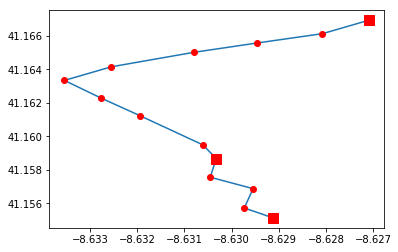

In [15]:
'''
benchmark beginns
'''
start_time = current_milli_time()

new = coords.merge(stop_points,on=['lon','lat'],how='left')
new = new[new.time_y.isnull()]
new = new.rename(columns={"time_x": "tstart", "time_y": "tend"})
route = stop_points_cluster.append(new)
route = route.sort_values(by=['tstart']).reset_index(drop=True)

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------create_route: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------create_route: END----------")

print(stop_points)
print(route)
polt_point_data = route[['lon', 'lat']].values
polt_stop_point_data = stop_points_cluster[['lon', 'lat']].values
plt.plot(polt_point_data[:,0], polt_point_data[:,1])
plt.plot(polt_point_data[:,0], polt_point_data[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

## 2.2. Data Simplification 

In [16]:
'''
benchmark beginns
'''
start_time = current_milli_time()

part = []
simplified_coords = pd.DataFrame(columns=['lon','lat','tstart', 'tend'])
counter = 0
for index, point in route.iterrows():
    counter += 1
    current_point = [point['lon'], point['lat']]
    part.append(current_point)
    if (not math.isnan(point['tend']) and len(part) > 1) or (route.shape[0] == counter) :
        l_data = gps.rdp(part, 0.00025)
        for i in l_data:
            l_lon = i[0]
            l_lat = i[1]
            l_frame = pd.DataFrame({"lon": [l_lon], "lat": [l_lat]})
            simplified_coords = simplified_coords.append(l_frame)
        part = []
        part.append(current_point)
#print(simplified_coords)
#simplified_coords = simplified_coords.drop_duplicates(subset=None, keep='first', inplace=False).reset_index(drop=True)
#print(simplified_coords)
merged = route.merge(simplified_coords, on=['lon','lat'])
merged = merged.drop(['tstart_y', 'tend_y'], axis=1)
merged = merged.rename(columns={'tstart_x': 'tstart', 'tend_x': 'tend'})
#print(merged)
#print("{} gps points simplified to {} points".format(route.shape[0], simplified_coords.shape[0]))

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------data_simplification(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------data_simplification(...): END----------")

----------data_simplification(...): BEGIN----------
time consumption in ms: 22
----------data_simplification(...): END----------


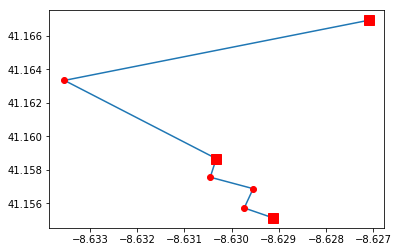

In [17]:
fig = plt.figure()
simplified_coords_plot = simplified_coords[['lon', 'lat']].values
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1])
plt.plot(simplified_coords_plot[:,0], simplified_coords_plot[:,1], 'ro')
plt.plot(polt_stop_point_data[:,0], polt_stop_point_data[:,1], 's', color='red', markersize= 10)

In [18]:
mplleaflet.display(fig=fig)

## 2.3. CSV Writer

In [19]:
'''
benchmark beginns
'''
start_time = current_milli_time()

p_point = pd.Series([])
p_point_e = False
header = False
lts = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing'])
for index, point in merged.iterrows():
    if p_point_e == False:
        pass
    else:
        # # print(point)
        brng = gps.bearingCalculator((p_point['lon'], p_point['lat']), (point['lon'], point['lat']))
        dis = gps.haversine((p_point['lon'], p_point['lat']), (point['lon'], point['lat']))
        lts_frame = pd.DataFrame(
            {'lon1': [p_point['lon']], 'lat1': [p_point['lat']], 'tstart1': [p_point['tstart']],
            'tend1': [p_point['tend']],
                 'lon2': [point['lon']], 'lat2': [point['lat']], 'tstart2': [point['tstart']], 'tend2': [point['tend']],
                 'distance': [dis], 'bearing': [brng]})
        lts = lts.append(lts_frame)
        # print(p_point, point)
        # print(brng, dis)
        p_point = point
        p_point_e = True

lts = lts.reset_index(drop=True)
    # print(lts)
if header == False:
    header = True
    lts.to_csv('test_lts.csv', header=True, sep=';', mode='w')  # header = 'False', index = 'True')
else:
    lts.to_csv('test_lts.csv', header=False, sep=';', mode='a')  # header = 'False', index = 'True')

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------write_to_csv(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------write_to_csv(...): END----------")



----------write_to_csv(...): BEGIN----------
time consumption in ms: 8
----------write_to_csv(...): END----------


## 2.4. Common  Segment  Discovery 

### alternative 

In [4]:
import numpy as np
global line_segments

line_segments = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route'])
with open('test_lts.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    route_id = 0 
    for row in csv_reader:
        if row[0] == '':
            pass
        else:
            if float(row[0]) == 0:
                route_id += 1
            # a short line segment might induce over-clustering, thus a the partitioning criteria is added
            if float(row[9]) >= 75:
                df = {'lon1': float(row[1]), 'lat1': float(row[2]), 'tstart1': float(row[3]), 'tend1': row[4],
                      'lon2': float(row[5]), 'lat2': float(row[6]), 'tstart2': float(row[7]), 'tend2': row[8],
                      'distance': row[9], 'bearing': row[10], 'route': route_id}
                line_segments = line_segments.append(df, ignore_index=True)

In [5]:
'''
Input: Zwei Linien als Pandas Series
Output: Die längere Line zuerst, dann die kürzere Line als Pandas Series
'''
def longer_and_shorter_lines(line_a, line_b):
    if line_a['distance'] > line_b['distance']:
        return (line_b, line_a)
    else:
        return (line_a, line_b)

#### test of projection points ps and pe

[-0.0011115 -0.001215 ]
[-0.0011115 -0.001215 ]
[-8.5867875 41.147307 ]
[-8.58626091 41.14788262]
-0.3857035655745071


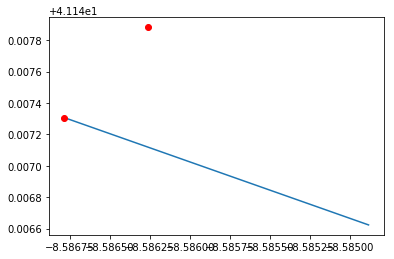

In [6]:
'''
Zum Testen und visualisieren der projection points Funktion
Eventuell muss Exception Handling eingebaut werden
'''

si = [-8.585676, 41.148522] 
ei = [-8.586787499506492, 41.14730700019343]
sj = [-8.586787499506492, 41.14730700019343]
ej = [-8.584884, 41.146623]

# ps
sisj = np.array([sj[0] - si[0], sj[1] - si[1]])
siei = np.array([ei[0] - si[0], ei[1] - si[1]])
print(sisj)
print(siei)
siei_norm = np.linalg.norm(siei)
u1 = np.dot(sisj, siei) / (siei_norm * siei_norm)
ps = si + u1 * siei
print(ps)

# pe
siej = np.array([ej[0] - si[0], ej[1] - si[1]])
u2 = np.dot(siej, siei) / (siei_norm * siei_norm)
pe = si + u2 * siei
print(pe)

# angle θ
sjej = np.array([ej[0] - sj[0], ej[1] - sj[1]])
cos_angle = np.dot(siei, sjej) / (np.linalg.norm(siei) * np.linalg.norm(sjej))
print(cos_angle)

fig = plt.figure()
# plt.plot([si[0], ei[0]], [si[1], ei[1]])
plt.plot([sj[0], ej[0]], [sj[1], ej[1]])
plt.plot(ps[0] , ps[1], 'ro')
plt.plot(pe[0] , pe[1], 'ro')
plt.show()

In [7]:
mplleaflet.display(fig=fig)

#### real implementation of projection points ps and pe function

In [8]:
def projection_points(line_a, line_b):
    '''
    si = [13.323899, 52.512749]
    ei = [13.332428,  52.513389]
    sj = [13.325390,  52.513223]
    ej = [13.328577,  52.514398]
    '''
    si = line_a['si']
    ei = line_a['ei']
    sj = line_b['sj']
    ej = line_b['ej']
    
    # ps
    sisj = np.array([sj[0] - si[0], sj[1] - si[1]])
    siei = np.array([ei[0] - si[0], ei[1] - si[1]])
    siei_norm = np.linalg.norm(siei)
    u1 = np.dot(sisj, siei) / (siei_norm * siei_norm)
    ps = si + u1 * siei
    
    # pe
    siej = np.array([ej[0] - si[0], ej[1] - si[1]])
    u2 = np.dot(siej, siei) / (siei_norm * siei_norm)
    pe = si + u2 * siei

    # angle θ
    sjej = np.array([ej[0] - sj[0], ej[1] - sj[1]])
    cos_angle = np.dot(siei, sjej) / (np.linalg.norm(siei) * np.linalg.norm(sjej))
        
    return (pe, ps, cos_angle)


#### distance functions

In [9]:
def distance_functions(line_a, line_b):
    '''
    si = [13.323899, 52.512749]
    ei = [13.332428,  52.513389]
    sj = [13.325390,  52.513223]
    ej = [13.328577,  52.514398]
    '''
    si = line_a['si']
    ei = line_a['ei']
    sj = line_b['sj']
    ej = line_b['ej']
    
    '''
    if (si == sj and ei == ej) or (si == ei or sj == ej):
        return 0
    '''
    
    pe, ps, cos_angle = projection_points(line_a, line_b)
    
    def perpendicular_distance(line_a, line_b):
        l1 = np.linalg.norm(ps-sj)
        l2 = np.linalg.norm(pe-ej)
        dist = (l1*l1+l2*l2)/l1+l2
        return dist

    def parallel_distance(line_a, line_b):
        l1 = min(np.linalg.norm(si-ps), np.linalg.norm(ei-ps))
        l2 = min(np.linalg.norm(si-pe), np.linalg.norm(ei-pe))
        dist = min(l1, l2)
        return dist

    def angle_distance(line_a, line_b):
        nonlocal cos_angle
        if (cos_angle) > 1:
            cos_angle = 1
        angle = math.acos(cos_angle)
        sjej = np.array([ej[0] - sj[0], ej[1] - sj[1]])
        dist = 0
        # print("angle: {}".format(np.degrees(angle)))
        if np.degrees(angle) >= 0 and np.degrees(angle) < 90:
            dist = np.linalg.norm(sjej) * math.sin(angle)
        elif np.degrees(angle) >= 90 and np.degrees(angle) <= 180:
            dist = np.linalg.norm(sjej)
        return dist

    perpendicular_distance = perpendicular_distance(line_a, line_b)
    parallel_distance = parallel_distance(line_a, line_b)
    angle_distance = angle_distance(line_a, line_b)
    
    # print("perpendicular_distance: {}".format(perpendicular_distance))
    # print("parallel_distance: {}".format(parallel_distance))
    # print("angle_distance: {}".format(angle_distance))
    
    '''
    Per Diffinition ist die Distanz die Addierte Distanzen der verschiedenen Funktionen,
    eine Gewichting kann noch erfolgen falls notwendig
    '''
    
    return (perpendicular_distance + parallel_distance + angle_distance)
    
    
    

### Algorithm Line Segment Clustering Implementation 

In [10]:
from rtree import index

def r_tree():
    idx = index.Index()

    for entry in line_segments.iterrows():
        ls_id = entry[0]
        lon1, lat1 = entry[1]['lon1'], entry[1]['lat1']
        lon2, lat2 = entry[1]['lon2'], entry[1]['lat2']
        min_x = min(lon1, lon2)
        max_x = max(lon1, lon2)
        min_y = min(lat1, lat2)
        max_y = max(lat1, lat2)
        idx.insert(ls_id, (min_x - 0.0005, min_y - 0.0005, max_x + 0.0005, max_y + 0.0005))

    return idx

    '''
    a = list(idx.intersection((-8.610876, 41.145570 , -8.608857, 41.147259)))
    a.sort() 
    print(a)
    '''



In [11]:
'''
Berechnet die Nachbarschaft indem die Distanz der Input Line mit allen anderen Linien verglichen wird:
The ε-neighborhood Nε(Li) of a line segment Li ∈DisdefinedbyNε(Li)={Lj ∈D|dist(Li,Lj)≤ε
'''
# Compute Nε(L);
def neighborhood(line, cluster_id, extended, rtree): 
    neighbors = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
    n_candidates = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])

    # r tree index
    lon1, lat1 = line[1]['lon1'], line[1]['lat1']
    lon2, lat2 = line[1]['lon2'], line[1]['lat2']
    min_x = min(lon1, lon2)
    max_x = max(lon1, lon2)
    min_y = min(lat1, lat2)
    max_y = max(lat1, lat2)
    n_candidates_ids = list(rtree.intersection((min_x, min_y, max_x, max_y)))
    n_candidates = line_segments.iloc[n_candidates_ids,:]
    
    for entry in n_candidates.iterrows():
        is_classified = entry[1]['classified']
        
        if (not extended and is_classified <= 0) or extended:    
            if not line[1].equals(entry[1]):
                line_longer, line_shorter = longer_and_shorter_lines(line[1], entry[1])
                line_a = {'si': [line_longer[0], line_longer[1]], 'ei': [line_longer[4], line_longer[5]]}
                line_b = {'sj': [line_shorter[0], line_shorter[1]], 'ej': [line_shorter[4], line_shorter[5]]}
                '''
                Parameter ε ist aktuell 0.0005
                '''
                if distance_functions(line_a, line_b) < 0.0005:
                    # line_segments.set_value(entry[0],'classified',cluster_id)
                    neighbors = neighbors.append(entry[1])
    return neighbors
    

In [12]:
# /* Step 2: compute a density-connected set */
def expand_cluster(queue, cluster_id, rtree):
    global line_segments
    # print("----------------input queue start----------------")
    # print(queue)
    # print("----------------input queue ended----------------")
    cluster = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
    while queue.shape[0] != 0:
        neighbors = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
        for entry in queue.iterrows():
            # Let M be the first line segment in Q;
            m = entry
            break
        # Compute Nε(M);
        neighbors = neighbors.append(neighborhood(m, cluster_id, True, rtree))
        neighbor_count = neighbors.shape[0] + 1
        # if (|Nε(M)| ≥ MinLns) then
        if (neighbor_count >= 2):
            for xn in neighbors.iterrows():
                #if (X is unclassified or noise) then
                if xn[1]['classified'] == -1 or xn[1]['classified'] == 0:
                    # line_segments.set_value(xn[0], 'classified', cluster_id)
                    # Assign clusterId to X;
                    line_segments.at[xn[0],'classified'] = cluster_id
                    series = pd.Series({'lon1': float(xn[1][0]), 'lat1': float(xn[1][1]), 'tstart1': float(xn[1][2]), 'tend1': xn[1][3],
                          'lon2': float(xn[1][4]), 'lat2': float(xn[1][5]), 'tstart2': float(xn[1][6]), 'tend2': xn[1][7],
                          'distance': xn[1][8], 'bearing': xn[1][9], 'route': xn[1][10], 'classified': cluster_id})
                    series.name = xn[0]
                    cluster = cluster.append(series)
                # if (X is unclassified) then
                if xn[1]['classified'] == -1:
                    # Insert X into the queue Q;
                    series = pd.Series({'lon1': float(xn[1][0]), 'lat1': float(xn[1][1]), 'tstart1': float(xn[1][2]), 'tend1': xn[1][3],
                          'lon2': float(xn[1][4]), 'lat2': float(xn[1][5]), 'tstart2': float(xn[1][6]), 'tend2': xn[1][7],
                          'distance': xn[1][8], 'bearing': xn[1][9], 'route': xn[1][10], 'classified': cluster_id})
                    series.name = xn[0]
                    queue = queue.append(series)
        # Remove M from the queue Q;
        queue = queue.iloc[1:]
        
        # print("----------------output queue start----------------")
        # print(queue)
        # print("----------------output queue ended----------------")
        
    # print("_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    # print(cluster)
    # print("_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-")
    return cluster
        
    

In [13]:
'''
benchmark beginns
'''
start_time = current_milli_time()

global line_segments

np.seterr(invalid='ignore', divide='ignore')

# initialize a r-tree as a index
rtree = r_tree()

# /* Step 1 */
# Set clusterId to be 0; /* an initial id */
cluster_id = 1
line_segments['classified'] = -1
neighbors = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
queue = pd.DataFrame(columns=['lon1', 'lat1', 'tstart1', 'tend1', 'lon2', 'lat2', 'tstart2', 'tend2', 'distance', 'bearing', 'route', 'classified'])
clusters = []

'''
die Spalte classified der Dataframes kann folgende Werte besitzen:
-1 := unclassified
-2 := noise
>= 0 := die entsprechende Segmente (Cluster)

Output dieser Zelle:
1.) Modifiziertes Dataframe der line_segments (Ausgangsdaten der test_lts.csv) mit der Routennummer und classified Status
2.) cluster: eine Liste mit Dataframes, die die Segmente (Cluster) darstellen
'''

for entry in line_segments.iterrows():
    entry = (entry[0], line_segments.loc[[entry[0]]].iloc[0])
    is_classified = entry[1]['classified']
    if is_classified == -1:
        # Compute Nε(L);
        neighbors = neighbors.append(entry[1])
        neighbors = neighbors.append(neighborhood(entry, cluster_id, False, rtree))
        neighbor_count = neighbors.shape[0]
        '''
        Parameter MinLns ist aktuell 3
        '''
        if neighbor_count >= 1:
            # Assign clusterId to ∀X ∈ Nε(L);
            neighbors['classified'] = cluster_id
            # line_segments.set_value(entry[0], 'classified' , cluster_id)
            line_segments.at[entry[0],'classified'] = cluster_id
            # Insert Nε(L) − {L} into the queue Q;
            queue = queue.append(neighbors.tail(neighbor_count - 1))
            # /* Step 2 */
            neighbors = neighbors.append(expand_cluster(queue, cluster_id, rtree))
            # print("????????????????????????????")
            # print(neighbors)
            # print("????????????????????????????")
            for index in neighbors.index.values.tolist():
                line_segments.set_value(index, 'classified' , cluster_id)
            neighbors.drop_duplicates(keep='first', inplace=True)
            '''
            clusters ist eine Liste mit allen Linien eines gemeinsamen Segments
            '''
            clusters.append(neighbors)
            # Increase clusterId by 1; /* a new id */
            cluster_id += 1
        else:
            # Mark L as noise;
            # line_segments.set_value(entry[0],'classified', -2)
            line_segments.at[entry[0],'classified'] = 0
            if entry[0] == 4:
                print("What should i do? First")
                
    neighbors = neighbors.iloc[0:0]
    queue = queue.iloc[0:0]
    
    '''
    Aktuell auf 4 Segmente (Cluster) beschränkt (aus Testzwecken / Performance)
    
    if cluster_id == 5:
        break
    '''
'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------Line Segment Clustering: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------Line Segment Clustering: END----------")


----------Line Segment Clustering: BEGIN----------
time consumption in ms: 128273
----------Line Segment Clustering: END----------


In [14]:
# /* Step 3 */
# /* check the trajectory cardinality */

final_cluster = []

for segment in clusters:
    # print(segment)
    # print(segment.route.nunique())
    '''
    Parameter MinLns ist aktuell 3
    '''
    # if (|PTR(C)| < MinLns) then
    if segment.route.nunique() >= 0:
        # Remove C from the set O of clusters;
        final_cluster.append(segment)
        
print("----")
for segment in final_cluster:
    print(segment.route.nunique())

----
1
5
12
5
1
2
2
1
1
1
4
2
2
1
5
1
2
1
2
7
2
4
3
1
6
1
1
1
1
1
1
2
1
3
4
2
7
1
1
1
1
2
1
2
1
2
3
1
1
1
1
1
1
1
1
1
1
4
1
1
2
2
1
1
1
1
3
1
1
4
1
8
2
1
2
2
3
4
1
12
1
1
1
1
1
2
2
2
4
2
2
1
2
1
1
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
2
5
3
5
8
6
4
1
1
7
3
3
1
2
14
1
8
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
3
1
1
1
1
1
1
1
1
2
2
1
2
1
9
1
1
1
1
2
1
20
5
23
9
1
2
2
4
3
2
1
1
3
5
4
1
2
1
1
2
1
1
1
1
1
2
1
1
1
1
3
3
1
2
4
1
1
1
1
1
1
2
1
4
2
3
1
1
6
1
1
1
1
1
1
1
1
1
1
1
7
2
14
4
1
1
2
2
11
2
3
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
1
1
1
1
1
1
1
1
1
1
4
4
1
1
2
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
5
1
1
20
15
1
1
1
1
1
1
1
1
1
2
1
1
14
2
12
2
1
1
1
2
1
1
1
1
2
1
2
1
1
1
1
1
1
1
2
9
2
1
9
12
3
4
9
3
2
1
6
5
3
1
2
1
1
2
1
1
1
1
1
1
1
2
1
1
2
1
1
1
2
8
1
9
1
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
2
6
2
1
1
1
1
1
1
1
1
1
1
4
2
1
1
9
1
1
1
2
1
7
1
1
1
2
1
2
1
1
1
2
1
2
1
1
2
1
2
2
1
5
1
4
1
3
5
1
3
1

#### data comparison

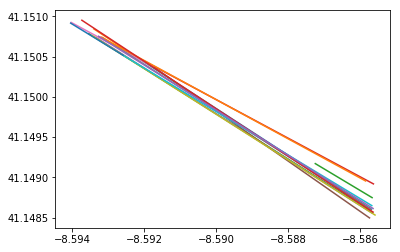

----------cluster via search: BEGIN----------
time consumption in ms: 433
----------cluster via search(...): END----------


In [15]:
'''
benchmark beginns
'''
start_time = current_milli_time()

fig = plt.figure()
for entry in line_segments.iterrows():
    '''
    Das Ändern der 1 in der if-Abfrage, ändert das Testcluster 
    '''
    if entry[1]['classified'] == 80:        
        # plot
        lon = [entry[1][0], entry[1][4]]
        lat = [entry[1][1], entry[1][5]]
        plt.plot(lon, lat)
#lon = [-8.608857000310614, -8.608179000357707]
#lat = [41.14725900005238, 41.148348000069426]
#plt.plot(lon, lat, 'ro')
#plt.plot(lon, lat, 'r')

#lon = [-8.60736600000288, -8.606358]
#lat = [41.14992000000163, 41.151915]
#plt.plot(lon, lat, 'bo')
#plt.plot(lon, lat, 'b')

plt.show()

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------cluster via search: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------cluster via search(...): END----------")

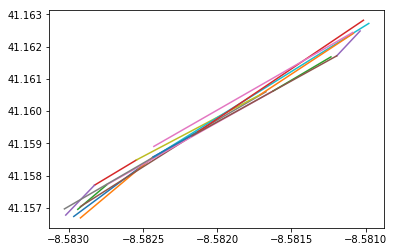

----------cluster via list: BEGIN----------
time consumption in ms: 155
----------cluster via list: END----------


,lon1,lat1,tstart1,tend1,lon2,lat2,tstart2,tend2,distance,bearing,route,classified
21,-8.582967,41.156739,345.0,360.0,-8.582427,41.158580,390.0,405.0,209.58803696051476,66.1825472628185,3,20
2070,-8.582922,41.156694,390.0,,-8.582432,41.158584,435.0,450.0,214.13270943584592,68.66697671107391,144,20
269,-8.582940,41.156960,375.0,390.0,-8.582742,41.157729,405.0,420.0,87.15537984822427,68.86002092341772,30,20
282,-8.582828,41.157707,465.0,480.0,-8.582544,41.158490,495.0,510.0,90.2426298551716,61.44919891941606,31,20
281,-8.583021,41.156782,405.0,450.0,-8.582828,41.157707,465.0,480.0,104.09575717815387,72.54042074557827,31,20
73,-8.582922,41.157045,480.0,,-8.582171,41.159232,510.0,525.0,251.18980777743334,62.65485214538944,10,20
270,-8.582742,41.157729,405.0,420.0,-8.581623,41.160624,480.0,510.0,335.2631745811744,59.79075173415299,30,20
3842,-8.583030,41.156973,465.0,,-8.581671,41.160600,480.0,,419.04434878761634,60.547745675821204,293,20
283,-8.582544,41.158490,495.0,510.0,-8.581712,41.160506,555.0,570.0,234.75301172310566,58.13657249055001,31,20
22,-8.582427,41.158580,390.0,405.0,-8.580978,41.162715,450.0,,475.57685363399196,62.13336160471238,3,20


In [16]:
'''
benchmark beginns
'''
start_time = current_milli_time()

fig = plt.figure()
counter = 1
# jupyter only:
printer = None 
for entry in clusters:
    '''
    Das Ändern der 1 in der if-Abfrage, ändert das Testcluster 
    '''
    if counter == 20:
        entry
        for data in entry.iterrows():
            printer = entry
            lon = [data[1][0], data[1][4]]
            lat = [data[1][1], data[1][5]]
            plt.plot(lon, lat)
    counter += 1
plt.show()

'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------cluster via list: BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------cluster via list: END----------")

printer

In [17]:
mplleaflet.display(fig=fig)

### Representative Trajectory Generation

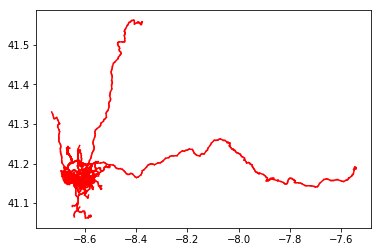

In [18]:
'''
simple linear regression 
'''

from sklearn.linear_model import LinearRegression


counter = 0
fig = plt.figure()

for entry in clusters:
    '''
    Das Ändern der 1 in der if-Abfrage, ändert das Testcluster 
    '''
    if counter != -1:
        lon1_list = entry['lon1'].values.tolist()
        lon2_list = entry['lon2'].values.tolist()
        lon1_list.extend(lon2_list)
        x_list = np.array(lon1_list).reshape(-1, 1)
        lat1_list = entry['lat1'].values.tolist()
        lat2_list = entry['lat2'].values.tolist()
        lat1_list.extend(lat2_list)
        y_list = np.array(lat1_list).reshape(-1, 1)
        
        linear_regressor = LinearRegression()  # create object for the class
        linear_regressor.fit(x_list, y_list)  # perform linear regression
        Y_pred = linear_regressor.predict(x_list)  # make predictions

        # plt.plot(x_list, y_list, 'bo')
        plt.plot(x_list, Y_pred, color='red')

    counter += 1
plt.show()

In [19]:
mplleaflet.show(fig=fig)

In [20]:
'''
Schreibt das modifizierte Dataframe der line_segments in eine neue CSV (test_seg.csv)
'''



'''
benchmark beginns
'''
start_time = current_milli_time()

print(line_segments)
# line_segments.to_csv('test_seg.csv', header=True, sep=';', mode='w')  # header = 'False', index = 'True')

inputSP = ''
eins = ' -1 '
zwei = '-2\n'
route = 2
for entry in line_segments.iterrows():
    if( entry[1]['route'] == route):
        cluster = str(entry[1]['classified'])
        inputSP = inputSP + cluster
        inputSP = inputSP + eins
        #print('if:' + cluster + 'String: ' + inputSP)
    else:
        route += 1
        cluster = str(entry[1]['classified'])
        inputSP = inputSP + zwei + cluster + eins
        #print('else:' + cluster + 'String: ' + inputSP)
        
print(inputSP)        
        
        #.join(['num' for num in xrange(loop_count)])


'''
benchmark ends
'''
time = (current_milli_time() - start_time) 
print("----------write_to_csv(...): BEGIN----------")
print("time consumption in ms: {}".format(time))
print("----------write_to_csv(...): END----------")

          lon1       lat1  tstart1  tend1      lon2       lat2  tstart2  \
0    -8.585676  41.148522      0.0   90.0 -8.586787  41.147307    120.0   
1    -8.586787  41.147307    120.0  135.0 -8.584884  41.146623    150.0   
2    -8.610876  41.145570      0.0   30.0 -8.608857  41.147259     75.0   
3    -8.608857  41.147259     75.0  105.0 -8.608179  41.148348    120.0   
4    -8.608179  41.148348    120.0  150.0 -8.607366  41.149920    180.0   
5    -8.607366  41.149920    180.0  210.0 -8.606358  41.151915    240.0   
6    -8.606358  41.151915    240.0        -8.604981  41.153319    270.0   
7    -8.604981  41.153319    270.0        -8.604805  41.154359    285.0   
8    -8.604805  41.154359    285.0  300.0 -8.604371  41.160652    375.0   
9    -8.604120  41.161242    435.0  525.0 -8.603910  41.162049    540.0   
10   -8.603910  41.162049    540.0        -8.602740  41.162972    555.0   
11   -8.602740  41.162972    555.0  570.0 -8.601894  41.163597    585.0   
12   -8.585739  41.148558

-2
1 -1 -2
2 -1 -2
3 -1 -2
4 -1 -2
4 -1 -2
4 -1 -2
5 -1 -2
6 -1 -2
7 -1 -2
8 -1 -2
9 -1 -2
10 -1 -2
11 -1 -2
12 -1 -2
13 -1 -2
14 -1 -2
15 -1 -2
16 -1 -2
17 -1 -2
18 -1 -2
19 -1 -2
20 -1 -2
20 -1 -2
21 -1 -2
22 -1 -2
23 -1 -2
24 -1 -2
25 -1 -2
26 -1 -2
27 -1 -2
28 -1 -2
29 -1 -2
30 -1 -2
31 -1 -2
2 -1 -2
32 -1 -2
33 -1 -2
15 -1 -2
34 -1 -2
35 -1 -2
36 -1 -2
37 -1 -2
38 -1 -2
39 -1 -2
40 -1 -2
41 -1 -2
42 -1 -2
43 -1 -2
44 -1 -2
45 -1 -2
46 -1 -2
47 -1 -2
48 -1 -2
49 -1 -2
50 -1 -2
51 -1 -2
52 -1 -2
53 -1 -2
54 -1 -2
55 -1 -2
56 -1 -2
57 -1 -2
11 -1 -2
12 -1 -2
13 -1 -2
58 -1 -2
15 -1 -2
34 -1 -2
35 -1 -2
59 -1 -2
37 -1 -2
60 -1 -2
61 -1 -2
20 -1 -2
20 -1 -2
20 -1 -2
62 -1 -2
63 -1 -2
64 -1 -2
65 -1 -2
66 -1 -2
67 -1 -2
67 -1 -2
68 -1 -2
69 -1 -2
70 -1 -2
71 -1 -2
72 -1 -2
73 -1 -2
74 -1 -2
75 -1 -2
76 -1 -2
77 -1 -2
78 -1 -2
78 -1 -2
78 -1 -2
78 -1 -2
79 -1 -2
80 -1 -2
80 -1 -2
81 -1 -2
82 -1 -2
83 -1 -2
84 -1 -2
85 -1 -2
86 -1 -2
87 -1 -2
88 -1 -2
89 -1 -2
90 -1 -2
91 -1 -2
92 -1 -2
9

In [21]:
from rtree import index
idx = index.Index()

for entry in line_segments.iterrows():
    ls_id = entry[0]
    lon1, lat1 = entry[1]['lon1'], entry[1]['lat1']
    lon2, lat2 = entry[1]['lon2'], entry[1]['lat2']
    min_x = min(lon1, lon2)
    max_x = max(lon1, lon2)
    min_y = min(lat1, lat2)
    max_y = max(lat1, lat2)
    idx.insert(ls_id, (min_x, min_y, max_x, max_y))

a = list(idx.intersection((-8.608857000310614, 41.14725900005238 , -8.608179000357707, 41.148348000069426)))
b = list(idx.nearest((-8.608857000310614, 41.14725900005238 , -8.608179000357707, 41.148348000069426), 10))
a.sort() 
b.sort() 
print(a)
print(b)


[2, 3, 4, 446, 556, 557, 598, 698, 699, 1122, 1420, 1423, 1434, 1623, 1864, 1865, 1910, 1920, 1982, 2210, 2405, 2406, 2432, 2516, 2517, 2583, 2584, 2585, 2913, 2914, 3032, 3201, 3202, 3410, 3430, 3517, 3518, 3539, 3540, 3619, 3766, 3858, 3859, 4037, 4123]
[2, 3, 4, 446, 556, 557, 598, 698, 699, 1122, 1420, 1423, 1434, 1623, 1864, 1865, 1910, 1920, 1982, 2210, 2405, 2406, 2432, 2516, 2517, 2583, 2584, 2585, 2913, 2914, 3032, 3201, 3202, 3410, 3430, 3517, 3518, 3539, 3540, 3619, 3766, 3858, 3859, 4037, 4123]


### ----------------------------------------------------------------------------------------------------------------------------------

In [117]:
routes = []
points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
p_points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
with open('test_lts.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';')
    header = True
    p_index = -1
    for row in csv_reader:
        #polt_point_data = route[['lon', 'lat']].values
        if header == True:
            header = False
        else:
            if p_index >= 0 and int(row[0]) == 0:
                p_points = p_points.append(df_alt, ignore_index=True)
                routes.append(p_points)
                points = pd.DataFrame(columns=['lon', 'lat', 'tstart', 'tend'])
            df = {'lon': float(row[1]), 'lat': float(row[2]), 'tstart': float(row[3]), 'tend': row[4]}
            df_alt = {'lon': float(row[5]), 'lat': float(row[6]), 'tstart': float(row[7]), 'tend': row[8]}
            points = points.append(df, ignore_index=True)
            p_index = int(row[0])
            p_points = points

In [179]:
fig = plt.figure()
counter = 0
for test in routes:
    
    plot = test[['lon', 'lat']].values
    plt.plot(plot[:,0], plot[:,1])
    plt.plot(plot[:,0], plot[:,1], 'ro', markersize=3)
    counter += 1
plt.show()

NameError: name 'routes' is not defined

<Figure size 432x288 with 0 Axes>

In [180]:
mplleaflet.show(fig=fig)

# ------------------------------------------------------------------------------------------

#### lines that belong to the same LTS in LG, are merged into one line, LG = {L,...,Lm,...,Lij}

In [104]:
new_lg = pd.DataFrame(columns=['lon1', 'lat1', 'lon2', 'lat2', 'distance', 'route', 'segments', 'classified'])
f_entry = None
p_entry = None
counter = 0
# itterate through all segment clusters (LTS)
for entry in clusters:
    counter += 1
    
    # test break (verification with 3, 10, 19, 20)
    if counter == 20: 
        # list of all routes in a segment cluster (LTS)
        distinct_routes = entry.route.unique().tolist()
        
        for i in distinct_routes:
            route = entry.loc[entry['route'] == i]
            route = route.sort_values(by=['tstart1'])
            first_line = route.iloc[0]
            last_line = route.iloc[-1]
            dis = gps.haversine((first_line[0], first_line[1]), (last_line[4], last_line[5]))
            
            line_ids = route.index.values
            # line_ids = np.array2string(line_ids)
            df = pd.DataFrame({
                 'lon1': first_line[0], 
                    'lat1': first_line[1], 
                    'lon2': last_line[4], 
                    'lat2': last_line[5], 
                    'distance': dis, 
                    'route': i,
                    'segments': [line_ids],
                'classified': first_line['classified']
                }, index=[0])
            new_lg = new_lg.append(df)

new_lg
        

,lon1,lat1,lon2,lat2,distance,route,segments,classified
0,-8.582967,41.156739,-8.580978,41.162715,685.045618,3,"[21, 22]",20
0,-8.582922,41.156694,-8.581014,41.162814,699.007640,144,"[2070, 2071, 2072]",20
0,-8.582940,41.156960,-8.581233,41.161680,544.001023,30,"[269, 270, 271]",20
0,-8.583021,41.156782,-8.581082,41.162409,646.444821,31,"[281, 282, 283, 284]",20
0,-8.582922,41.157045,-8.581037,41.162481,624.725701,10,"[73, 74, 75]",20
0,-8.583030,41.156973,-8.581671,41.160600,419.044349,293,[3842],20
0,-8.582427,41.158908,-8.581086,41.162436,408.042430,167,[2306],20


In [93]:
new_lg = pd.DataFrame({
                 'lon1': [-8.586792, -8.586994500277642, -8.586963, -8.587206],
                    'lat1': [41.147217, 41.14742850007364, 41.147163, 41.147298],
                    'lon2': [-8.584992,-8.584317, -8.584902, -8.585613,  ],
                    'lat2': [41.146749, 41.146461, 41.146497, 41.146776],
                    'distance': [159.44944171837886, 248.66957514667655, 187.7916518308266, 145.46759413639467], 
                    'route': [7.0, 30.0, 221.0, 301.0],
                    'segments': [[39], [278],[3161],[4099]],
                'classified':[1, 1, 1, 1]
                }, index=[0,0,0,0])
new_lg

,lon1,lat1,lon2,lat2,distance,route,segments,classified
0,-8.586792,41.147217,-8.584992,41.146749,159.449442,7.0,[39],1
0,-8.586995,41.147429,-8.584317,41.146461,248.669575,30.0,[278],1
0,-8.586963,41.147163,-8.584902,41.146497,187.791652,221.0,[3161],1
0,-8.587206,41.147298,-8.585613,41.146776,145.467594,301.0,[4099],1


# ploting after merging

350
346
348
348


,lon1,lat1,lon2,lat2,distance,route,segments,classified
0,-8.586792,41.147217,-8.584992,41.146749,159.449442,7.0,[39],1
0,-8.586995,41.147429,-8.584317,41.146461,248.669575,30.0,[278],1
0,-8.586963,41.147163,-8.584902,41.146497,187.791652,221.0,[3161],1
0,-8.587206,41.147298,-8.585613,41.146776,145.467594,301.0,[4099],1


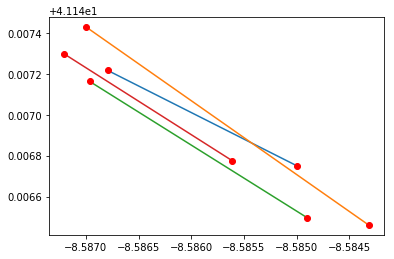

In [94]:
fig = plt.figure()
for i in new_lg.iterrows():
    lon_l = []
    lat_l= []
    p1_lon = i[1][0]
    p1_lat = i[1][1]
    p2_lon = i[1][2]
    p2_lat = i[1][3]
    
    bias = 0.00001
    
    #line_segments_test = line_segments.copy()
    #line_segments_old = line_segments
    #line_segments = line_segments_test
    
    #line_segments = line_segments_old
    
    print(round(gps.bearingCalculator((p1_lon, p1_lat), (p2_lon, p2_lat))))
    
    if round(gps.bearingCalculator((p1_lon, p1_lat), (p2_lon, p2_lat))) == 90 or round(gps.bearingCalculator((p1_lon, p1_lat), (p2_lon, p2_lat))) == 270:
        new_list = i[1]['segments']
        p1_lon += bias
        for j in new_list:
            #line_segments.at[j ,'lon1'] = p1_lon
            #new_lg.at[i[0],'lon1'] = p1_lon
            print(line_segments.iloc[j])
       
    
    lon_l.append(p1_lon)
    lat_l.append(p1_lat)
    lon_l.append(p2_lon)
    lat_l.append(p2_lat)
    plt.plot(lon_l, lat_l)
    plt.plot(lon_l, lat_l, 'ro')
    
        
new_lg


In [95]:
mplleaflet.display(fig=fig)

[38.43727575]
[[-0.31559302]]
-0.31559301573622406 -1 38.437275752919525


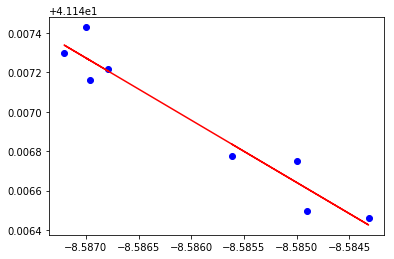

In [96]:
'''
simple linear regression 
'''

from sklearn.linear_model import LinearRegression
import numpy as np

lon1_list = new_lg['lon1'].values.tolist()
lon2_list = new_lg['lon2'].values.tolist()
lon1_list.extend(lon2_list)
x_list = np.array(lon1_list).reshape(-1, 1)
lat1_list = new_lg['lat1'].values.tolist()
lat2_list = new_lg['lat2'].values.tolist()
lat1_list.extend(lat2_list)
y_list = np.array(lat1_list).reshape(-1, 1)
        
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(x_list, y_list)  # perform linear regression
Y_pred = linear_regressor.predict(x_list)  # make predictions

# y=a+bx (Regressionsgerade)
# a
print(linear_regressor.intercept_) 
# b
print(linear_regressor.coef_)

# ausgehend von der Struktur Ax + By + C = 0 
# ist in diesem Fall:
A = linear_regressor.coef_[0][0]
B = -1
C = linear_regressor.intercept_[0]

print(A, B, C)

fig = plt.figure()
plt.plot(x_list, y_list, 'bo')
plt.plot(x_list, Y_pred, color='red')


def r_test(x):
    y_list = []
    for i in x:
        y = C + A * i
        y_list.append(y)
    return y_list


plt.show()

In [97]:
mplleaflet.display(fig=fig)

#### line projection
For each line L_i in LG, calculate the projection points of the endpoints on the representative line. ∀p(x_0 , y_0 ), the projection point on Ax + By + C = 0 can be calculated by:
$$ x' = (B^2 * x_0  - A*B*y_0 - A*C)/(A^2 +B^2) $$
$$ y' = (A^2 * y_0  - A*B*x_0 - B*C)/(A^2 +B^2) $$

[[-8.587194522228188, 41.1473343689031],
 [-8.587039634111648, 41.147285487295306],
 [-8.586934786570282, 41.14725239814353],
 [-8.586794773725666, 41.14720821106765],
 [-8.585595994372479, 41.14682988467638],
 [-8.585023493816236, 41.14664920749932],
 [-8.584869319933363, 41.14660055129868],
 [-8.584326975519787, 41.146429391189635]]

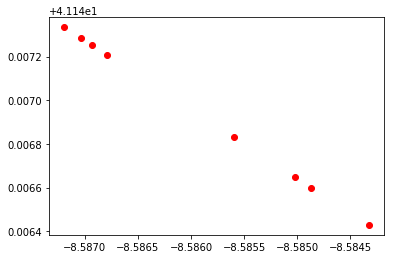

In [98]:
# plt.figure(figsize=(10, 10))
fig = plt.figure()

a = A
b = B
c = C
lon_l = []
lat_l= []
projection_lg = pd.DataFrame(columns=['lon1', 'lat1', 'lon2', 'lat2', 'route', 'segments'])
for i in new_lg.iterrows():
    p1_lon = i[1][0]
    p1_lat = i[1][1]
    x1 = (b * b * p1_lon - a * b * p1_lat - a * c) / (a * a + b * b)
    y1 = (a * a * p1_lat - a * b * p1_lon - b * c) / (a * a + b * b)
    p2_lon = i[1][2]
    p2_lat = i[1][3]
    x2 = (b * b * p2_lon - a * b * p2_lat - a * c) / (a * a + b * b)
    y2 = (a * a * p2_lat - a * b * p2_lon - b * c) / (a * a + b * b)
    save_x1 = x1
    save_y1 = y1
    if x1 > x2:
        x1 = x2
        y1 = y2
        x2 = save_x1
        y2 = save_y1
    df = pd.DataFrame({
        'lon1': x1, 
        'lat1': y1,
        'lon2': x2, 
        'lat2': y2, 
        'route': i[1][5],
        'segments': [i[1][6]]
        }, index=[0])
    lon_l.append(x1)
    lat_l.append(y1)
    lon_l.append(x2)
    lat_l.append(y2)
    projection_lg = projection_lg.append(df)
    plt.plot([x1, x2], [y1,y2], 'ro')

x_lon = np.asarray(lon_l).reshape(-1, 1)
y_lat = np.asarray(lat_l).reshape(-1, 1)

projection_points = np.concatenate((x_lon,y_lat),axis=1).tolist()   

projection_points.sort()
projection_lg = projection_lg.sort_values(by=['lon1'])


projection_lg
projection_points



In [99]:
mplleaflet.display(fig=fig)

[[-8.585658, 41.1484895], [-8.585658, 41.1484895]]
[-8.587194522228188, -8.586794773725666, -8.585595994372479, -8.585595994372479, -8.585023493816236, -8.584869319933363, -8.584326975519787, -8.584326975519787]


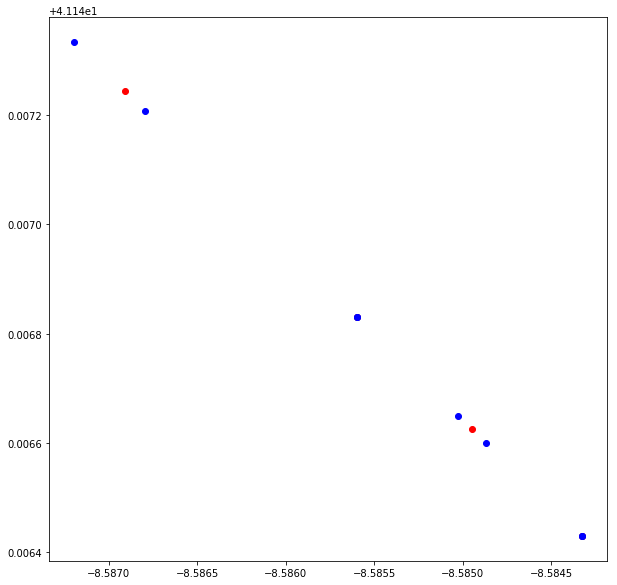

In [100]:
import gps_utils as gps
plt.figure(figsize=(10, 10))


'''

# boundaries 
#new_lg = new_lg.reset_index()
index = new_lg['distance'].argmax()
b_lon1 = new_lg.iloc[index]['lon1']
b_lon2 = new_lg.iloc[index]['lon2']


'''

# Richtung beachten
'''
TODO
Eventually, the lines have to marked in this step.
Need a closer look an the centroid calculation. 
lon1 = lon1 or lon1 = lon2

Neuer Ansatz immer die äßersten Punkte speichern und dann später die aüßteren punkte vergleichen
'''
'''
if b_lon1 > b_lon2:
    b_lon1 = b_lon2
    b_lon2 = save
'''
# die projektionspunkte 
final_projection_points = []
# list mit min, max lon wert eines Punktes (speziell cluster mit centroid)
test_list = []
p_point = None
merged = False
first = True
last_point = None
debug = []
for point in projection_points:
    x = round(point[0], 6)
    if p_point is not None:
        distance = gps.haversine(point, p_point)
        if distance >= 50:
            if merged == False:
                # auch punkte ohne in einem cluster , bekommen min und max lon der vollständigkeits halber
                final_projection_points.append(p_point)
                test_list += 2 * [p_point[0]]
            if merged:
                test_list.append(p_point_max)
                first = True
            last_point = point
            merged = False
        else:
            # print(point)
            lon = [p_point[0], point[0]]
            lat = [p_point[1], point[1]]
            save_point = point
            point = middle_p = list(gps.centroid(lon, lat))
            p_point_max = lon[1]
            if first:
                test_list.append(lon[0])
                debug.append(save_point)
                first = False
            if merged:
                del final_projection_points[-1]
            final_projection_points.append(middle_p)
            merged = True
    p_point = point
# um es abzuschließen
if merged:
    test_list.append(p_point_max)
else:
    test_list += 2 * [last_point[0]]
    final_projection_points.append(last_point)
    

    


        
for test in final_projection_points:
    #plt.plot(test[0], test[1])
    plt.plot(test[0], test[1], 'ro')
    pass
    
for test in test_list:
    plt.plot(test, r_test([test])[0])
    plt.plot(test, r_test([test])[0], 'bo')
    pass
    
b_lon_l = [round(new_lg.loc[0]['lon1'], 6), round(new_lg.loc[0]['lon2'], 6)]
b_lat_l = [new_lg.loc[0]['lat1'], new_lg.loc[0]['lat2']]
# plt.plot(b_lon_l, r_test(b_lon_l),'s', color='green')

if len(final_projection_points) == 1:
    results = []
    new_list = []
    for i in test_list:
        y = r_test([i])[0]
        new_list += 2*[i]
        results.append([i, y])
    final_projection_points = results
    test_list = new_list 

print(results)
print(test_list)

In [101]:
test_lg = pd.DataFrame(columns=['lon1', 'lat1', 'lon2', 'lat2', 'min_x1', 'max_x1', 'min_x2', 'max_x2'])

lon1 = None
counter = 0
l_id = 0
for i in final_projection_points:
    lon2 = i[0]
    lat2 = i[1]
    print(i)
    if (lon1 is not None):
        df = pd.DataFrame({
            'lon1': lon1, 
            'lat1': lat1, 
            'lon2': lon2, 
            'lat2': lat2,
            'min_x1': test_list[counter],
            'max_x1': test_list[counter+1],
            'min_x2': test_list[counter+2],
            'max_x2': test_list[counter+3]
        }, index=[l_id])
        test_lg = test_lg.append(df)
        lon1 = None
        counter += 2
        l_id += 1
    lon1 = lon2 
    lat1 = lat2

    
test_lg.loc[0, 'lon1'] 

# representiv line segments    
test_lg

[-8.586910352956377, 41.14724468717672]
[-8.585595994372479, 41.14682988467638]
[-8.5849464068462, 41.1466248794247]
[-8.584326975519787, 41.146429391189635]


,lon1,lat1,lon2,lat2,min_x1,max_x1,min_x2,max_x2
0,-8.586910,41.147245,-8.585596,41.146830,-8.587195,-8.586795,-8.585596,-8.585596
1,-8.585596,41.146830,-8.584946,41.146625,-8.585596,-8.585596,-8.585023,-8.584869
2,-8.584946,41.146625,-8.584327,41.146429,-8.585023,-8.584869,-8.584327,-8.584327


In [102]:
id_list = []
p_test_lg = pd.DataFrame(columns=['lon1', 'lat1', 'lon2', 'lat2', 'min_x1', 'max_x1', 'min_x2', 'max_x2'])
loop_break = False
for entry in projection_lg.iterrows():
    e_lon1 = entry[1][0]
    e_lat1 = entry[1][1]
    e_lon2 = entry[1][2]
    e_lat2 = entry[1][3]
    # linenvergleich beginnt
    for line in test_lg.iterrows():
        # jede line in test_lg eigenschaften
        min_x1 = line[1][4]
        max_x1 = line[1][5]
        min_x2 = line[1][6]
        max_x2 = line[1][7]
        print(e_lon1, min_x1, e_lon1, max_x2, e_lon2, max_x2)
        print(e_lon1 >= min_x1, e_lon1 < max_x2, e_lon2 <= max_x2)
        if e_lon1 >= min_x1 and e_lon1 < max_x2 and e_lon2 <= max_x2:
            id_list.append([line[0]])
            break
        elif p_test_lg.shape[0]:
            for test in p_test_lg.iterrows():
                if e_lon1 >= test[1]['min_x1'] and e_lon1 < max_x2 and e_lon2 <= max_x2 and e_lon1 < test[1]['max_x2']:
                    id_list.append([test[0], line[0]])
                    loop_break = True
                    break
            if loop_break:
                loop_break = False
                break
        p_test_lg = p_test_lg.append(line[1])
    p_test_lg = p_test_lg.iloc[0:0]
    


if len(id_list) != new_lg.shape[0]:
    id_list.append([0])
    

new_lg['sub_segment'] = id_list 
new_lg

-8.587194522228188 -8.587194522228188 -8.587194522228188 -8.585595994372479 -8.585595994372479 -8.585595994372479
True True True
-8.587039634111648 -8.587194522228188 -8.587039634111648 -8.585595994372479 -8.584326975519787 -8.585595994372479
True True False
-8.587039634111648 -8.585595994372479 -8.587039634111648 -8.584869319933363 -8.584326975519787 -8.584869319933363
False True False
-8.587039634111648 -8.585023493816236 -8.587039634111648 -8.584326975519787 -8.584326975519787 -8.584326975519787
False True True
-8.586934786570282 -8.587194522228188 -8.586934786570282 -8.585595994372479 -8.584869319933363 -8.585595994372479
True True False
-8.586934786570282 -8.585595994372479 -8.586934786570282 -8.584869319933363 -8.584869319933363 -8.584869319933363
False True True
-8.586794773725666 -8.587194522228188 -8.586794773725666 -8.585595994372479 -8.585023493816236 -8.585595994372479
True True False
-8.586794773725666 -8.585595994372479 -8.586794773725666 -8.584869319933363 -8.58502349381

,lon1,lat1,lon2,lat2,distance,route,segments,classified,sub_segment
0,-8.586792,41.147217,-8.584992,41.146749,159.449442,7.0,[39],1,[0]
0,-8.586995,41.147429,-8.584317,41.146461,248.669575,30.0,[278],1,"[0, 2]"
0,-8.586963,41.147163,-8.584902,41.146497,187.791652,221.0,[3161],1,"[0, 1]"
0,-8.587206,41.147298,-8.585613,41.146776,145.467594,301.0,[4099],1,"[0, 1]"


In [103]:
# update the classified id with the new sub segments
print(new_lg.iloc[0]['classified'])
for lg in new_lg.iterrows():
    segments = lg[1]['segments']
    sub_segment = lg[1]['sub_segment']
    cluster = lg[1]['classified']
    print(segments)
    new_cluster = cluster * 10000
    for ls in list(segments):
        cluster_seg = []
        i = sub_segment[0]
        while i <= sub_segment[-1]:
            new_id = new_cluster + i
            cluster_seg.append(new_id)
            i += 1
        print(cluster_seg)
        print(line_segments.iloc[ls])
        line_segments.at[ls ,'classified'] = str(cluster_seg)
        # print(ls)
        # print(cluster_seg)
        


1
[39]
[10000]
lon1                    -8.57975
lat1                     41.1465
tstart1                      210
tend1                           
lon2                     -8.5787
lat2                     41.1501
tstart2                      240
tend2                           
distance      408.75743599945014
bearing        66.25553432140413
route                          7
classified                    35
Name: 39, dtype: object


ValueError: invalid literal for int() with base 10: '[10000]'

In [87]:
line_segments
for i in line_segments.iterrows():
    if i[1]['route'] == 11:
        print(i[1])

lon1                    -8.59123
lat1                     41.1627
tstart1                        0
tend1                       75.0
lon2                     -8.5898
lat2                     41.1637
tstart2                      105
tend2                      150.0
distance      163.06129845156744
bearing         25.0875677213308
route                         11
classified                    76
Name: 91, dtype: object
lon1                     -8.5898
lat1                     41.1637
tstart1                      105
tend1                      150.0
lon2                    -8.58917
lat2                     41.1646
tstart2                      165
tend2                      225.0
distance      111.52122162904514
bearing        43.32403737937648
route                         11
classified                    77
Name: 92, dtype: object
lon1                    -8.58917
lat1                     41.1646
tstart1                      165
tend1                      225.0
lon2                    -8.5

In [69]:
range (24*1000, 24*1000 + 20)

range(24000, 24020)

# ---------------------------------------------------------------------------------------

#### calculating the representative line of LG, Ax + By + C = 0
the angle θ is the mean angle in LG in:
$$\theta = \frac{1}{k}   \sum_{i=1}^{k} \theta_i, \theta \in [0, \pi)$$

In [92]:
summe = 0
k = 0
for i in new_lg.iterrows():
    angle = i[1][9]
    k += 1
    if angle > 90 and angle <= 180:
        angle = 180 - angle
    elif angle > 180 :
        angle = 360 - angle
    print(i[1][9])
    print(angle)
    summe += angle
avg = (1 / k) * summe
print(avg)

177.27197509385
2.7280249061500115
177.51108521305662
2.4889147869433828
355.7875876466649
4.212412353335083
356.1344980739305
3.8655019260694985
3.323713493124494


##### the least squares straight line fitting is used to calculate the parameters of the representative line:
$$ C = \frac{1}{k} \sum_{i=1}^{k} ( -Ax_i - By_i), \begin{cases} A=1, B=0; \theta = \frac{\pi}{2} \\A = - tan \theta, B = 1; \theta  \neq \frac{\pi}{2} \end{cases} $$ 
where (x_i, y_i) is the endpoint of L_i in LG
$$ hint: \pi = 180 $$

In [93]:
cc = 0
k = 0
a = 0
b = 0
for i in new_lg.iterrows():
    k += 1
    if (avg == 90):
        a = 1
        b = 0
    else:
        a = -math.tan(avg)
        b = 1
    x = i[1][4]
    y = i[1][5]
    print(a, b, x, y)
    cc += (-a * x - b * y)
    print(cc)
c = (1/k) * cc
print(a,b,c)

# Ax + By + C = 0 -> y = (-Ax - C) / B
def fun(xi):
    return (-a * xi - c) / b


-0.18416144495095743 1 13.32344 52.512739
-50.05907503788262
-0.18416144495095743 1 13.325543 52.51302
-100.11804378424651
-0.18416144495095743 1 13.333343 52.513777
-150.17633307133977
-0.18416144495095743 1 13.325855 52.512876
-200.23510035933282
-0.18416144495095743 1 -50.058775089833205


##### plot of representative line of LG, Ax + By + C = 0

[13.333203, 13.32344, 13.333053, 13.325543, 13.327722, 13.333343, 13.323687, 13.325855]
[52.51423702013764, 52.51243905195059, 52.5142093959209, 52.51282634346932, 52.51322763125787, 52.514262802739935, 52.51248453982749, 52.51288380184015]


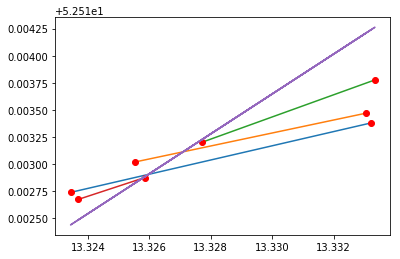

In [94]:
fig = plt.figure()

for i in new_lg.iterrows():
    lon_l = []
    lat_l= []
    p1_lon = i[1][0]
    p1_lat = i[1][1]
    lon_l.append(p1_lon)
    lat_l.append(p1_lat)
    p2_lon = i[1][4]
    p2_lat = i[1][5]
    lon_l.append(p2_lon)
    lat_l.append(p2_lat)
    plt.plot(lon_l, lat_l)
    plt.plot(lon_l, lat_l, 'ro')
    
rl_lon_l = []
rl_lat_l = []
for i in new_lg.iterrows():
    p1_lon = i[1][0]
    p1_lat = fun(p1_lon)
    rl_lon_l.append(p1_lon)
    rl_lat_l.append(p1_lat)
    p2_lon = i[1][4]
    p2_lat = fun(p2_lon)
    rl_lon_l.append(p2_lon)
    rl_lat_l.append(p2_lat)
print(rl_lon_l)
print(rl_lat_l)
plt.plot(rl_lon_l, rl_lat_l)


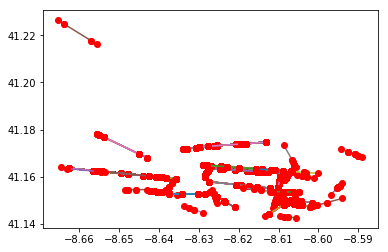

In [160]:
import matplotlib.pyplot as plt
import pandas as pd
fig =plt.figure()
with open('/Users/jiafug/Desktop/DBPRO/Codev2/results.txt') as results:
    data=pd.read_csv("/Users/jiafug/Desktop/DBPRO/Codev2/representative_trajectories.csv",
                     sep=";",
                     index_col=0,
                     header=None, 
                     names=['lon1', 'lat1', 'lon2', 'lat2', 'min_x1', 'max_x1', 'min_x2', 'max_x2'])
        
    for i in results:
        line=i
        line=line.replace("-1","").replace("-2","")
        # print(line)
        entries = line.split("#")
        abc = entries[1].split(": ")
        sup = abc[1].replace("\n", "")
        # print(int(sup))
        final = entries[0].split("  ")
        del final[-1]
        # print(final)
        
        x_list = []
        y_list = []
        
        if len(final) >= 3 and int(sup) >= 20:
            for i in final:
                save = data.loc[int(i)]
                lon1 = save['lon1']
                lat1 = save['lat1']
                lon2 = save['lon2']
                lat2 = save['lat2']
                
                x_list += [lon1, lon2]
                y_list += [lat1, lat2]
                
            #print(x_list)
            #print(y_list)
            plt.plot(x_list,y_list)
            plt.plot(x_list,y_list, 'ro')
        # break
                   
                    
                
                       
                        
    plt.show()  

In [161]:
mplleaflet.show(fig=fig)